In [94]:
import scipy.io
from scipy.stats import bootstrap
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.optimizers import AdamW, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import L1, L2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, normalize, MinMaxScaler
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Load .mat file
mat = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_1.mat')
mat2 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_2.mat')
mat3 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_3.mat')

# Extract and reshape data
Temp_all = mat.get('T_GaN_random')
Spectra_all = mat.get('Spectrum')

temp_combined = np.concatenate((Temp_all, mat2.get('T_GaN_random'), mat3.get('T_GaN_random')), axis=2)
spectra_combined = np.concatenate((Spectra_all, mat2.get('Spectrum'), mat3.get('Spectrum')), axis=2)

# temp_T = Temp_all.transpose(2, 0, 1)
# spectra_T = Spectra_all.transpose(2, 0, 1)

# temp_row = temp_T[:, 0, :]
# spectra_row = spectra_T[:, 0, :]


temp_line = temp_combined.reshape(10000, 50)
spectra_line = spectra_combined.reshape(10000, 355)




# Create pandas DataFrame
pd_spectra = pd.DataFrame(spectra_line)
pd_temp = pd.DataFrame(temp_line)

# Select the data
X = pd_spectra.iloc[0:10000]
Y = pd_temp.iloc[0:10000]

# X_min = np.min(X)
# X_max = np.max(X)

# X_denom = X_max - X_min
# X_numer = X - X_min

# X_normal = X_numer/X_denom


# Y_min = np.min(Y)
# Y_max = np.max(Y)

# Y_denom = Y_max - Y_min
# Y_numer = Y - Y_min

# Y_normal = Y_numer/Y_denom

scalerX, scalerY = RobustScaler(), MinMaxScaler()
X_scaled = scalerX.fit_transform(X) * (-1)
# Y_scaled = scalerY.fit_transform(Y)

# X_scaled = pd.DataFrame(X_scaled)
# Y_scaled = pd.DataFrame(Y_scaled)

# X_normal = normalize(X)

# X = -np.log(X)

# Scale the features using RobustScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Create polynomial features
# poly = PolynomialFeatures(degree=2, include_bias=True)
# X_poly = poly.fit_transform(X_normal)

# # Apply PCA for dimensionality reduction
# pca = PCA(n_components=50)  # Adjust n_components based on variance explained
# X_pca = pca.fit_transform(X_poly)

# # Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.10, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=1337)



# y_train_normal = (y_train - Y_min) / (Y_denom)
# y_test_normal = (y_test - Y_min) / (Y_denom)
# y_val_normal = (y_val - Y_min) / (Y_denom)

# X_train_normal = normalize(X_train, norm="l1")
# X_val_normal = normalize(X_val, norm="l1")
# X_test_normal = normalize(X_test, norm="l1")

In [95]:
X_scaled

array([[0.55379268, 0.562247  , 0.53929532, ..., 0.55302576, 0.5807809 ,
        0.56464921],
       [0.5332557 , 0.57232611, 0.53419611, ..., 0.55609378, 0.56429008,
        0.56149563],
       [0.5484057 , 0.57927659, 0.58354236, ..., 0.5541067 , 0.56416075,
        0.53886379],
       ...,
       [0.2033724 , 0.20287798, 0.20438631, ..., 0.20136651, 0.19843564,
        0.20309075],
       [0.2064182 , 0.20156712, 0.20503696, ..., 0.2003838 , 0.20565186,
        0.1994003 ],
       [0.2021814 , 0.20142856, 0.20704052, ..., 0.20222421, 0.20353332,
        0.20282777]])

Epoch 1/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 70886.8906 - mae: 248.1824 - val_loss: 24786.6445 - val_mae: 136.5188 - learning_rate: 0.0010
Epoch 2/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 16884.3730 - mae: 105.5424 - val_loss: 3513.7612 - val_mae: 40.3040 - learning_rate: 0.0010
Epoch 3/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1401.5002 - mae: 27.3203 - val_loss: 1073.6760 - val_mae: 27.6127 - learning_rate: 0.0010
Epoch 4/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 831.7457 - mae: 22.6130 - val_loss: 1159.0033 - val_mae: 26.3729 - learning_rate: 0.0010
Epoch 5/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 464.5662 - mae: 16.5086 - val_loss: 212.8337 - val_mae: 11.4368 - learning_rate: 0.0010
Epoch 6/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 504.0783 - mae: 17.4031 - val_loss: 566.4344 - val_mae: 19.0275 - learning_rate: 0.0010
Epoch 7/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 383.9658 - mae: 15.1959 - val_loss: 962

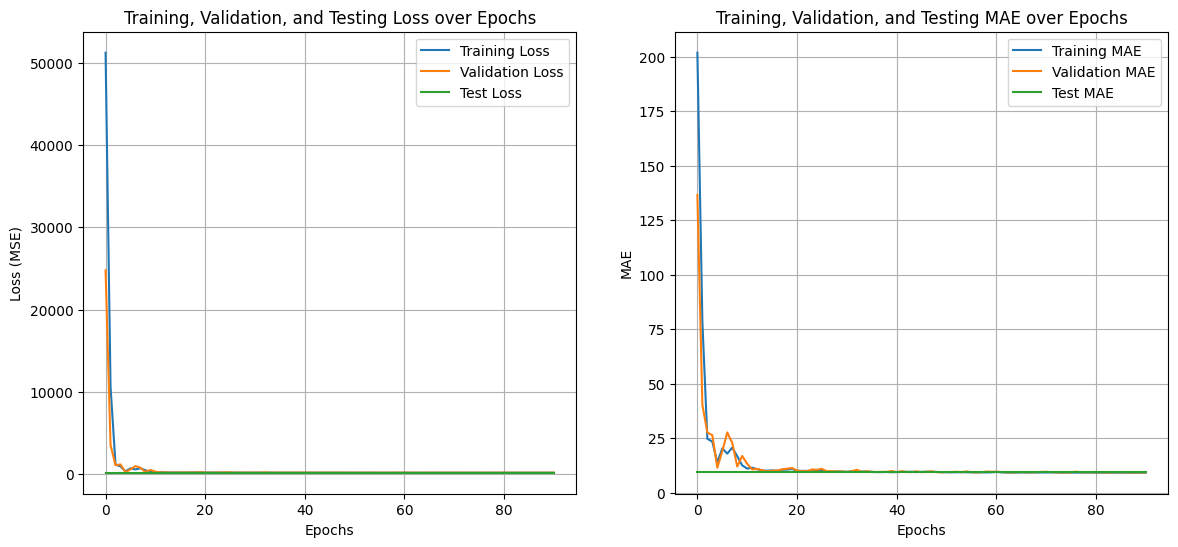

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.optimizers import RMSprop, Adam, SGD, AdamW, Adagrad
from keras.regularizers import l2
from keras.layers import LeakyReLU

# Define the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))

# Uncomment the following block if you want to add layers in a loop
# for i in range(100): 
#     model.add(Dense(30, activation=LeakyReLU()))
#     model.add(BatchNormalization())
#     # model.add(Dropout(0.3))

for _ in range(3):
    model.add(Dense(1024, activation='relu'))

for _ in range(4):
    model.add(Dense(512, activation='relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))
for _ in range(5):
    model.add(Dense(256, activation='relu'))

for _ in range(5):
    model.add(Dense(128, activation='relu'))
    
for _ in range(4):
    model.add(Dense(64, activation='relu'))

# for _ in range(30):
#     model.add(Dense(30, activation='leaky_relu', kernel_regularizer=l2(.00001)))

model.add(Dense(50, activation='linear'))


# Compile the model
rprop = RMSprop(learning_rate=0.001)
adam = AdamW(learning_rate=0.001)
sgd = SGD(learning_rate=0.0001)
ada = Adagrad(learning_rate=.01)
model.compile(optimizer=adam, loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=128, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])


# model.save('temperature_prediction.keras')
# Print training metrics
print(f"train_MSE: {history.history['loss'][-1]}")
print(f"train_MAE: {history.history['mae'][-1]}")

# Evaluate the model on the validation set
validation_loss, validation_mae = model.evaluate(X_val, y_val)
print(f"val_MSE: {validation_loss}, val_MAE: {validation_mae}")

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"test_MSE: {test_loss}, test_MAE: {test_mae}")

# Add test metrics to the history for plotting
history.history['test_loss'] = [test_loss] * len(history.history['loss'])
history.history['test_mae'] = [test_mae] * len(history.history['mae'])

# Plot training, validation, and test loss and mae values
plt.figure(figsize=(14, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.plot(history.history["test_loss"], label='Test Loss')
plt.title('Training, Validation, and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.plot(history.history["test_mae"], label="Test MAE")
plt.title('Training, Validation, and Testing MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


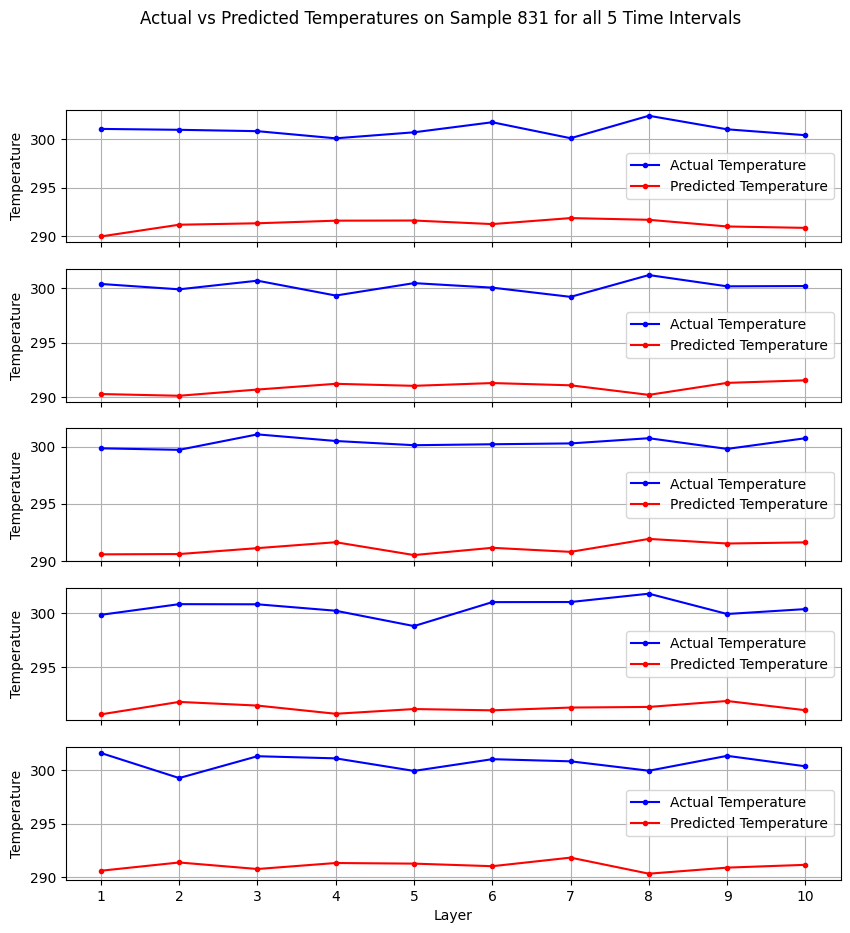

In [99]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# y_pred_inv = scalerY.inverse_transform(y_pred.reshape(-1, 50))

# y_test_inv = scalerY.inverse_transform(y_test.reshape(-1, 50))


# diff_min = np.min(np.abs(y_test_inv - y_pred_inv))
# diff_max = np.max(np.abs(y_test_inv - y_pred_inv))

# Select a random index for a 5x10 segment
random_index = np.random.randint(0, len(y_test))
actual_segment = pd.DataFrame(y_test).iloc[random_index].values.reshape(5, 10)
predicted_segment = y_pred[random_index].reshape(5, 10)

x = range(1, 11)

# Plot the selected segments
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
for i in range(5):
    axs[i].plot(x, actual_segment[i], 'b.-', label='Actual Temperature')
    axs[i].plot(x, predicted_segment[i], 'r.-', label='Predicted Temperature')
    plt.xlabel('Layer')
    plt.xticks(np.arange(1, 11, step=1))
    axs[i].set_ylabel('Temperature')
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Layer')
plt.suptitle(f"Actual vs Predicted Temperatures on Sample {random_index} for all 5 Time Intervals")
plt.show()


In [27]:
actual_std = np.std(y_test)
pred_std = np.std(y_pred)

/Users/kevinli/Desktop/sr2024/UNT-Thermography-24/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [29]:
actual_temp = pd.DataFrame(y_test).iloc[i].values.reshape(5, 10)
predicted_temp = pd.DataFrame(y_pred).iloc[i].values.reshape(5, 10)

actual_temp.shape
predicted_temp.shape

(5, 10)

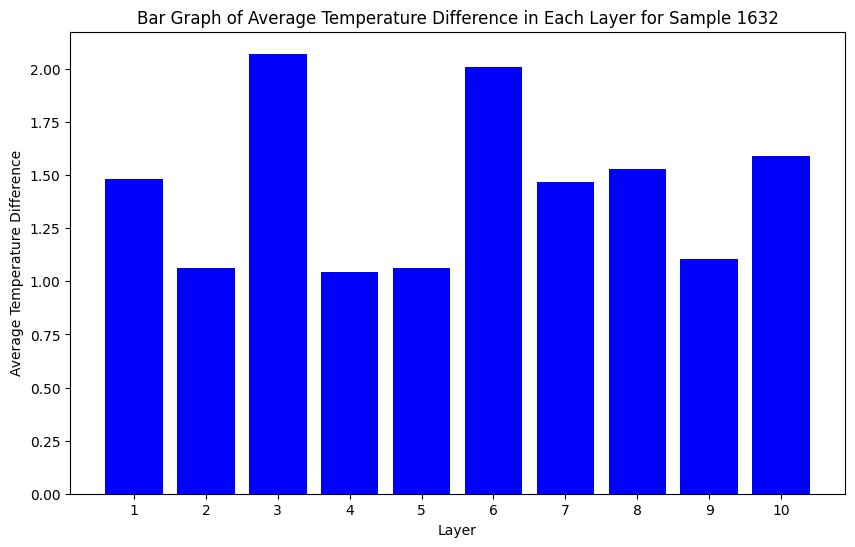

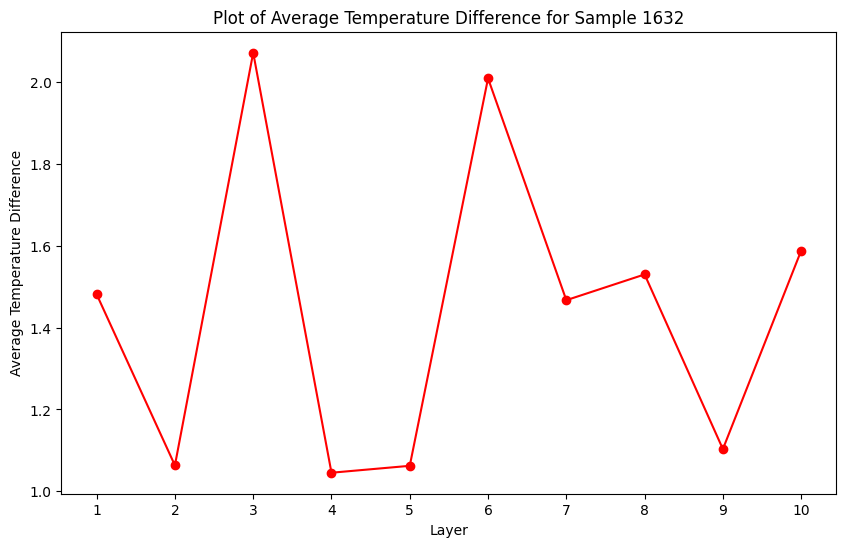

In [69]:
all_diff = []
for i in range(len(y_test)):
    actual_temp = pd.DataFrame(y_test).iloc[i].values.reshape(5, 10)
    predicted_temp = y_pred[i].reshape(5, 10)

    diff = actual_temp - predicted_temp

    all_diff.append(diff[None,:])

complete_diff = np.vstack(all_diff)

# len(complete_diff)

column_sums = np.sum(complete_diff, axis=1)

avg_temp_diff = column_sums / 5

# print("Array:\n", complete_diff)
# print("Sum of columns for each depth level:\n", column_sums)

avg_temp_diff

# random_index = np.random.randint(0, len(avg_temp_diff))
row_values = avg_temp_diff[random_index]

x = range(1, 11)

plt.figure(figsize=(10,6))
plt.bar(x, row_values, color='blue')

plt.title(f"Bar Graph of Average Temperature Difference in Each Layer for Sample {random_index+1}")
plt.xlabel("Layer")
plt.xticks(np.arange(1, 11, step=1))
plt.ylabel("Average Temperature Difference")

plt.figure(figsize=(10,6))
plt.plot(x, row_values, label=f"Sample {random_index+1}", color="r", linestyle='-', marker='o')

plt.title(f"Plot of Average Temperature Difference for Sample {random_index+1}")
plt.xlabel("Layer")
plt.xticks(np.arange(1, 11, step=1))
plt.ylabel("Average Temperature Difference")

plt.show()

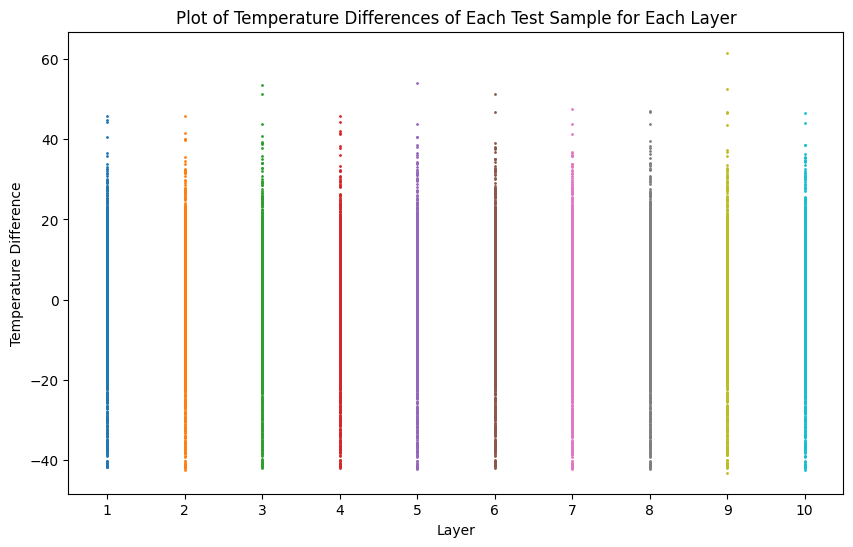

In [70]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each column of data
for i in range(10):
    ax.plot([i+1] * 2000, avg_temp_diff[:, i], 'o', markersize=1)

# Set the x-axis limits
ax.set_xlim(0.5, 10.5)

# Label the x-axis and y-axis
ax.set_xlabel('Layer')
plt.xticks(np.arange(1, 11, step=1))
ax.set_ylabel('Temperature Difference')

# Set the title
ax.set_title('Plot of Temperature Differences of Each Test Sample for Each Layer')

# Show the plot
plt.show()



In [74]:
diff = np.abs(y_test - y_pred)

diff_sum = np.sum(diff, axis=0)
diff_sum = diff_sum.to_numpy()

diff_sum = diff_sum.reshape(5, 10)
diff_avg = np.sum(diff_sum, axis=0) / 10000
diff_avg

array([10.7856486 , 10.78510711, 10.70398476, 10.73010805, 10.83429517,
       10.77250238, 10.84071627, 10.92261787, 10.824152  , 10.83498814])

In [75]:
np.mean(diff_avg)

10.803412034053041

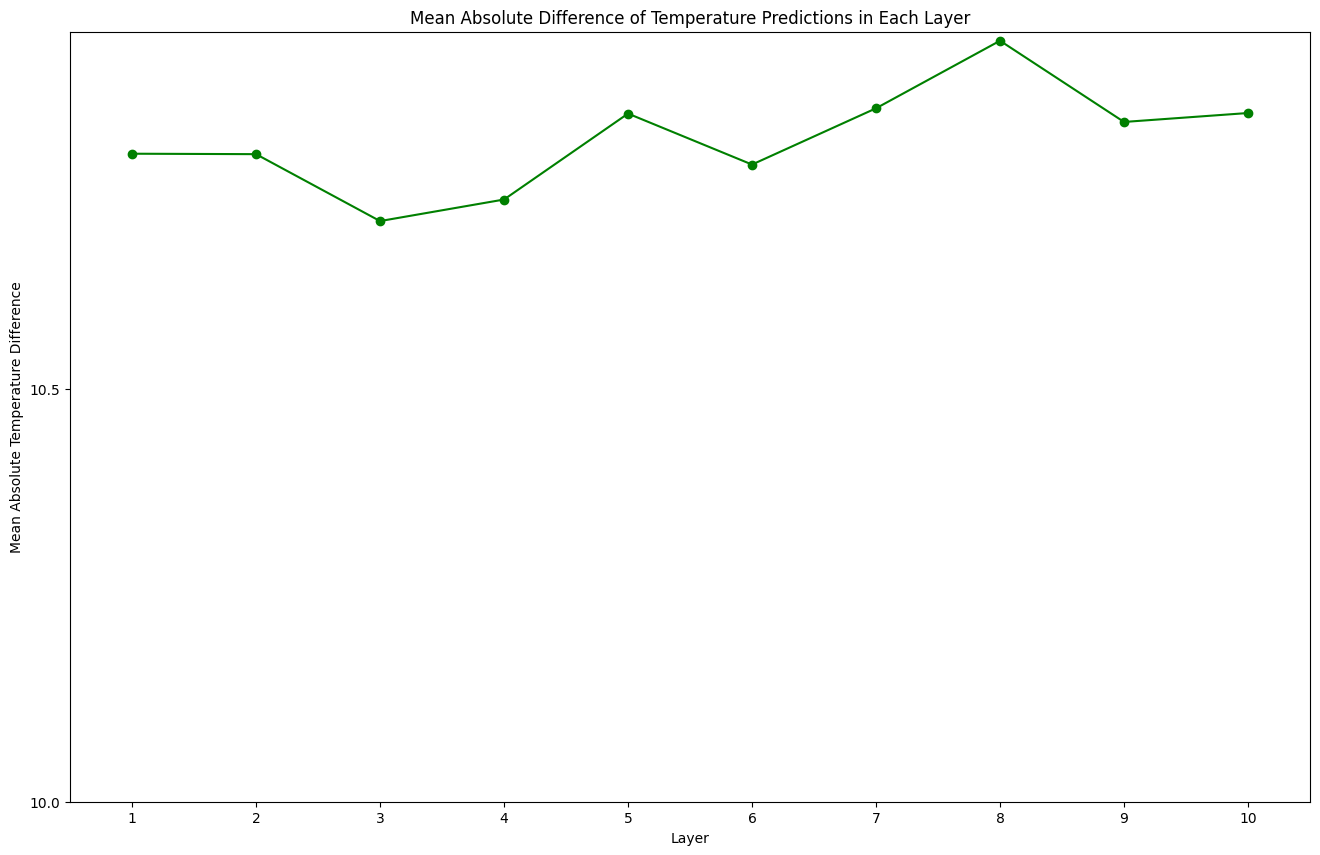

In [76]:
x = range(1, len(diff_avg) + 1)
plt.figure(figsize=(16, 10))
plt.plot(x, diff_avg, marker='o', color='g')
plt.xlim(0.5, 10.5)
plt.title("Mean Absolute Difference of Temperature Predictions in Each Layer")

plt.xlabel("Layer")
plt.xticks(np.arange(1, 11, step=1))
plt.ylabel("Mean Absolute Temperature Difference")
plt.yticks(np.arange(math.floor(np.min(diff_avg)), math.ceil(np.max(diff_avg)), step=.5))

plt.show()

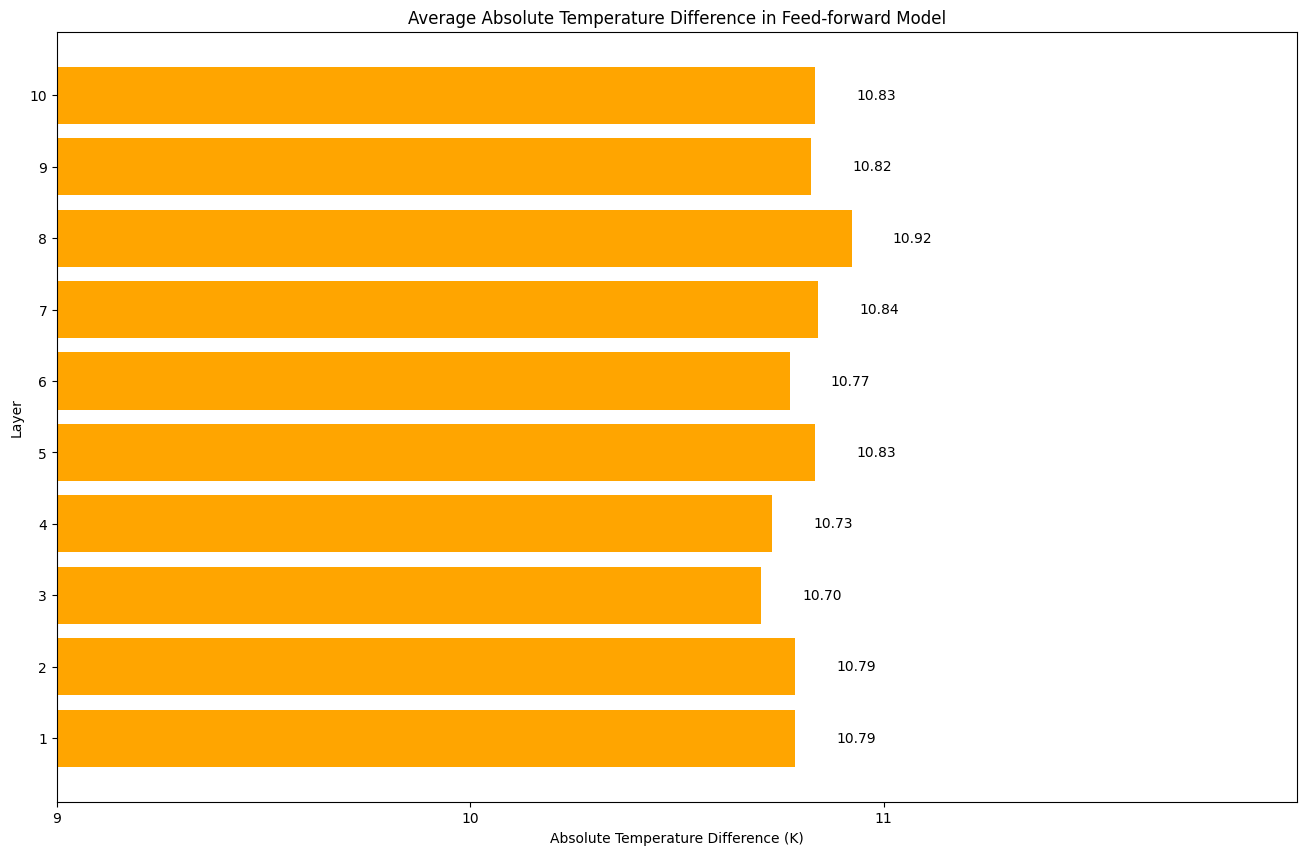

In [79]:
plt.figure(figsize=(16, 10))

# Plot horizontal bar graph
bars = plt.barh(x, diff_avg, color='orange')

# Set the x-axis limits if needed
plt.xlim(math.floor(np.min(diff_avg)), math.ceil(np.max(diff_avg)) + 1)

# Add title and labels
plt.title("Average Absolute Temperature Difference in Feed-forward Model")
plt.ylabel("Layer")
plt.xlabel("Absolute Temperature Difference (K)")

# Set y-ticks for layers
plt.yticks(np.arange(1, 11, step=1))

# Set x-ticks for temperature difference
plt.xticks(np.arange(math.floor(np.min(diff_avg)) - 1, math.ceil(np.max(diff_avg)) + 1, step=1))

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
             ha='left', va='center')

plt.show()

In [78]:
actual = np.sum(y_test, axis=0)

actual = actual.reshape(5, 10)
actual_avg = np.sum(actual, axis=0) / 2000

avg_relative_diff = (diff_avg / actual_avg) * 100

x = range(1, len(diff_avg) + 1)
plt.figure(figsize=(16, 10))
plt.plot(x, avg_relative_diff, marker='o', color='g')
plt.xlim(0.5, 10.5)
plt.title("Mean Absolute Difference of Temperature Predictions in Each Layer")

plt.xlabel("Layer")
plt.xticks(np.arange(1, 11, step=1))
plt.ylabel("Average Relative Temperature Difference")
plt.yticks(np.arange(math.floor(np.min(avg_relative_diff)), math.ceil(np.max(avg_relative_diff)), step=1))

plt.show()



AttributeError: 'Series' object has no attribute 'reshape'